<a href="https://colab.research.google.com/github/ericodle/Genre-Classification-Using-LSTM/blob/main/resnet18_init_and_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch

import torch.nn as nn

import torch.optim as optim

import torch.nn.functional as F

import numpy as np

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import time

import copy

import os

In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = '/content/drive/MyDrive/'

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [10]:
import torchvision

from torchvision.transforms.transforms import Grayscale

from torchvision import transforms

from torchvision import datasets


batch_size = 64


t = transforms.Compose(

[
    #transforms.Grayscale(),
    transforms.ToTensor()

])


dataset = datasets.ImageFolder(DATASET_PATH + 'mfcc_13', transform=t)

train_set, val_set = torch.utils.data.random_split(dataset, [900, 100])



train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)


In [5]:
print('train set size')
print(len(train_set))
print('val set size')
print(len(val_set))

train set size
900
val set size
100


In [30]:
from torchvision import models

net = models.resnet18(pretrained=True)

net = net.cuda() 

In [7]:
from graphviz import Digraph
from torch.autograd import Variable
import torch


def make_dot(var, params=None):
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style="filled", shape="box", align="left", fontsize="12", ranksep="0.1", height="0.2")
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return "(" + (", ").join(["%d" % v for v in size]) + ")"

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor="orange")
                dot.edge(str(id(var.grad_fn)), str(id(var)))
                var = var.grad_fn
            if hasattr(var, "variable"):
                u = var.variable
                name = param_map[id(u)] if params is not None else ""
                node_name = "%s\n %s" % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor="lightblue")
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, "next_functions"):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, "saved_tensors"):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)

    add_nodes(var)
    return dot

In [8]:
import torchvision.models as models

inputs = torch.randn(1, 3, 224, 224)
resnet18 = models.resnet18()
y = resnet18(inputs)
# print(y)

g = make_dot(y)
g.view()

'Digraph.gv.pdf'

In [31]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)


def accuracy(out, labels):

    _,pred = torch.max(out, dim=1)

    return torch.sum(pred==labels).item()


num_ftrs = net.fc.in_features

net.fc = nn.Linear(num_ftrs, 10)

net.fc = net.fc.cuda()

In [32]:
n_epochs = 50

print_every = 8

valid_loss_min = np.Inf

val_loss = []

val_acc = []

train_loss = []

train_acc = []

total_step = len(train_dataloader)

for epoch in range(1, n_epochs+1):

    running_loss = 0.0

    correct = 0

    total=0

    print(f'Epoch {epoch}\n')

    for batch_idx, (data_, target_) in enumerate(train_dataloader):

        data_, target_ = data_.to(device), target_.to(device)

        optimizer.zero_grad()

        

        outputs = net(data_)

        loss = criterion(outputs, target_)

        loss.backward()

        optimizer.step()


        running_loss += loss.item()

        _,pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred==target_).item()

        total += target_.size(0)

        if (batch_idx) % 20 == 0:

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 

                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))

    train_acc.append(100 * correct / total)

    train_loss.append(running_loss/total_step)

    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')

    batch_loss = 0

    total_t=0

    correct_t=0

    with torch.no_grad():

        net.eval()

        for data_t, target_t in (val_dataloader):

            data_t, target_t = data_t.to(device), target_t.to(device)

            outputs_t = net(data_t)

            loss_t = criterion(outputs_t, target_t)

            batch_loss += loss_t.item()

            _,pred_t = torch.max(outputs_t, dim=1)

            correct_t += torch.sum(pred_t==target_t).item()

            total_t += target_t.size(0)

        val_acc.append(100 * correct_t/total_t)

        val_loss.append(batch_loss/len(val_dataloader))

        network_learned = batch_loss < valid_loss_min

        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')


        

        if network_learned:

            valid_loss_min = batch_loss

            torch.save(net.state_dict(), 'resnet.pt')

            print('Improvement-Detected, save-model')

    net.train()

Epoch 1

Epoch [1/50], Step [0/15], Loss: 2.4940

train-loss: 1.7574, train-acc: 37.6667
validation loss: 2.0291, validation acc: 29.0000

Improvement-Detected, save-model
Epoch 2

Epoch [2/50], Step [0/15], Loss: 1.2756

train-loss: 1.4182, train-acc: 65.0000
validation loss: 1.7293, validation acc: 51.0000

Improvement-Detected, save-model
Epoch 3

Epoch [3/50], Step [0/15], Loss: 0.8214

train-loss: 1.2360, train-acc: 75.7778
validation loss: 1.4915, validation acc: 69.0000

Improvement-Detected, save-model
Epoch 4

Epoch [4/50], Step [0/15], Loss: 0.5557

train-loss: 1.0886, train-acc: 80.7778
validation loss: 1.3350, validation acc: 74.0000

Improvement-Detected, save-model
Epoch 5

Epoch [5/50], Step [0/15], Loss: 0.4647

train-loss: 0.9832, train-acc: 87.0000
validation loss: 1.2405, validation acc: 75.0000

Improvement-Detected, save-model
Epoch 6

Epoch [6/50], Step [0/15], Loss: 0.2936

train-loss: 0.8723, train-acc: 95.3333
validation loss: 1.1814, validation acc: 71.0000

E

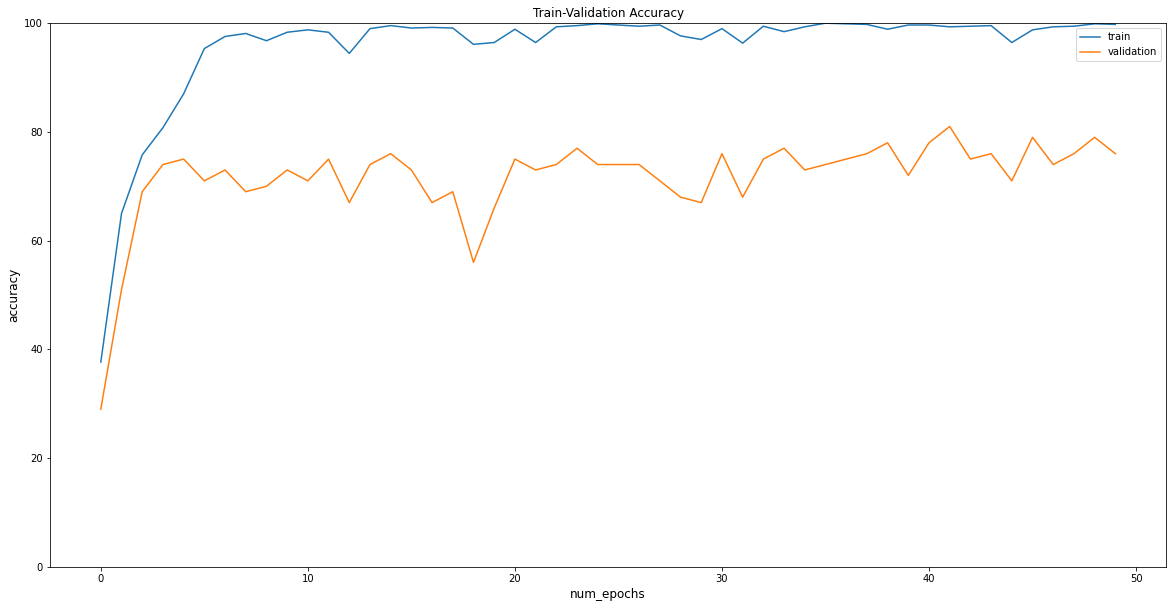

In [33]:
fig = plt.figure(figsize=(20,10))

plt.title("Train-Validation Accuracy")

plt.plot(train_acc, label='train')

plt.plot(val_acc, label='validation')

plt.xlabel('num_epochs', fontsize=12)

plt.ylabel('accuracy', fontsize=12)

plt.ylim((0,100))

plt.legend(loc='best')